# Árboles de decisión: Churn compañía de servicios de telefonía móvil

Vamos a aplicar un modelo de clasificación de árboles de decisión a un dataset que describe los clientes de una compañía que presta servicios de telefonía móvil que se han abandonado o no la compañía para irse a la competencia.

Importamos las librerías que vamos a utilizar

In [15]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import tree, datasets, metrics
#from sklearn import neighbors, datasets, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
import seaborn as sns
import math

## Entendimiento de los datos

Cargamos los datos para entenderlos

In [16]:
data = pd.read_csv('01_churn.csv', sep=';', na_values=".")
print(data.shape)
data.head(5)

(20000, 12)


COLLEGE  INCOME  OVERAGE  LEFTOVER   HOUSE  HANDSET_PRICE  \
0    zero   31953        0         6  313378            161   
1     one   36147        0        13  800586            244   
2     one   27273      230         0  305049            201   
3    zero  120070       38        33  788235            780   
4     one   29215      208        85  224784            241   

   OVER_15MINS_CALLS_PER_MONTH  AVERAGE_CALL_DURATION REPORTED_SATISFACTION  \
0                            0                      4                 unsat   
1                            0                      6                 unsat   
2                           16                     15                 unsat   
3                            3                      2                 unsat   
4                           21                      1            very_unsat   

  REPORTED_USAGE_LEVEL CONSIDERING_CHANGE_OF_PLAN  LEAVE  
0               little                         no   STAY  
1               little                considering   STAY  
2          very_little                    perhaps   STAY  
3            very_high                considering  LEAVE  
4               little              never_thought   STAY

**Parte 1**:
* Determine el número de registros, de variables, sus tipos ideales/reales, y sus rangos
* Determine el baseline (porcentaje clase mayoritaria)y su accuracy. ¿Están balanceados los datos (use diagrama de barras)?
* ¿Encuentran algún problema con los datos (missing values, datos inválidos, etc.)?
* Si fuésemos a utilizar K-NN, ¿debería hacerse algún pretratamiento de los datos?

El método **describe** permite obtener un dataframe con una descripción de las variables de un dataframe analizado. Para cada variable encontramos el número de registros validos (*count*).

Además, si se trata de una variable categórica, se puede obtener el número de clases posibles (*unique*), la clase mayoritaria (*top*) y la frecuencia de la clase mayoritaria (*freq*).

Y, si se trata de una variable numérica, se puede obtener el promedio (*mean*), desviación estándar (*std*), los valores mínimos (*min*) y máximos (*max*) y los cuartiles (*25%*, *50%* y *75%*).

In [17]:
data.describe(include = 'all')

COLLEGE         INCOME       OVERAGE      LEFTOVER          HOUSE  \
count    20000   20000.000000  20000.000000  20000.000000   20000.000000   
unique       2            NaN           NaN           NaN            NaN   
top        one            NaN           NaN           NaN            NaN   
freq     10048            NaN           NaN           NaN            NaN   
mean       NaN   80281.447750     85.979550     23.898650  493155.264250   
std        NaN   41680.586319     85.992324     26.816645  252407.884692   
min        NaN   20007.000000     -2.000000      0.000000  150002.000000   
25%        NaN   42217.000000      0.000000      0.000000  263714.250000   
50%        NaN   75366.500000     59.000000     14.000000  452259.500000   
75%        NaN  115881.750000    179.000000     41.000000  702378.000000   
max        NaN  159983.000000    335.000000     89.000000  999996.000000   

        HANDSET_PRICE  OVER_15MINS_CALLS_PER_MONTH  AVERAGE_CALL_DURATION  \
count    20000.000000                 20000.000000           20000.000000   
unique            NaN                          NaN                    NaN   
top               NaN                          NaN                    NaN   
freq              NaN                          NaN                    NaN   
mean       389.615100                     8.000700               6.002250   
std        213.820682                     8.925418               4.402558   
min        130.000000                     0.000000               1.000000   
25%        219.000000                     1.000000               2.000000   
50%        326.000000                     4.000000               5.000000   
75%        533.250000                    15.000000              10.000000   
max        899.000000                    29.000000              15.000000   

       REPORTED_SATISFACTION REPORTED_USAGE_LEVEL CONSIDERING_CHANGE_OF_PLAN  \
count                  20000                20000                      20000   
unique                     5                    5                          5   
top               very_unsat               little                considering   
freq                    7909                 7875                       7920   
mean                     NaN                  NaN                        NaN   
std                      NaN                  NaN                        NaN   
min                      NaN                  NaN                        NaN   
25%                      NaN                  NaN                        NaN   
50%                      NaN                  NaN                        NaN   
75%                      NaN                  NaN                        NaN   
max                      NaN                  NaN                        NaN   

        LEAVE  
count   20000  
unique      2  
top      STAY  
freq    10148  
mean      NaN  
std       NaN  
min       NaN  
25%       NaN  
50%       NaN  
75%       NaN  
max       NaN

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   COLLEGE                      20000 non-null  object
 1   INCOME                       20000 non-null  int64 
 2   OVERAGE                      20000 non-null  int64 
 3   LEFTOVER                     20000 non-null  int64 
 4   HOUSE                        20000 non-null  int64 
 5   HANDSET_PRICE                20000 non-null  int64 
 6   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 7   AVERAGE_CALL_DURATION        20000 non-null  int64 
 8   REPORTED_SATISFACTION        20000 non-null  object
 9   REPORTED_USAGE_LEVEL         20000 non-null  object
 10  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
 11  LEAVE                        20000 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB


In [19]:
data['LEAVE'].value_counts()

STAY     10148
LEAVE     9852
Name: LEAVE, dtype: int64

In [20]:
data['LEAVE'][data['LEAVE'] == 'STAY'].count()/data.shape[0]*100

50.739999999999995

<AxesSubplot:xlabel='LEAVE', ylabel='count'>

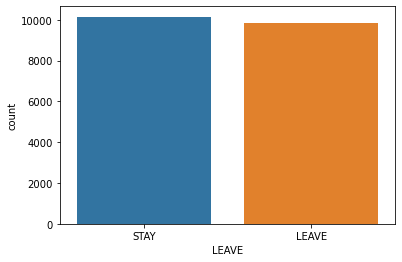

In [21]:
sns.countplot(x = 'LEAVE', data = data)

In [22]:
data.isna().sum()

COLLEGE                        0
INCOME                         0
OVERAGE                        0
LEFTOVER                       0
HOUSE                          0
HANDSET_PRICE                  0
OVER_15MINS_CALLS_PER_MONTH    0
AVERAGE_CALL_DURATION          0
REPORTED_SATISFACTION          0
REPORTED_USAGE_LEVEL           0
CONSIDERING_CHANGE_OF_PLAN     0
LEAVE                          0
dtype: int64

In [23]:
data.isnull().sum()

COLLEGE                        0
INCOME                         0
OVERAGE                        0
LEFTOVER                       0
HOUSE                          0
HANDSET_PRICE                  0
OVER_15MINS_CALLS_PER_MONTH    0
AVERAGE_CALL_DURATION          0
REPORTED_SATISFACTION          0
REPORTED_USAGE_LEVEL           0
CONSIDERING_CHANGE_OF_PLAN     0
LEAVE                          0
dtype: int64

**Parte 2**:

Utilizando pandas y matplotlib, analice la distribución de las variables independientes con respecto a los valores de la variable objetivo LEAVE y STAY. Trate de encontrar patrones en plots univariados (densidad) y Bivariados (scatterplots) para las variables numéricas, y gráficos de barras de conteo para las categóricas.

In [24]:
var_indep_cat = ['COLLEGE', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL',
       'CONSIDERING_CHANGE_OF_PLAN', 'LEAVE']

<AxesSubplot:xlabel='LEAVE', ylabel='count'>

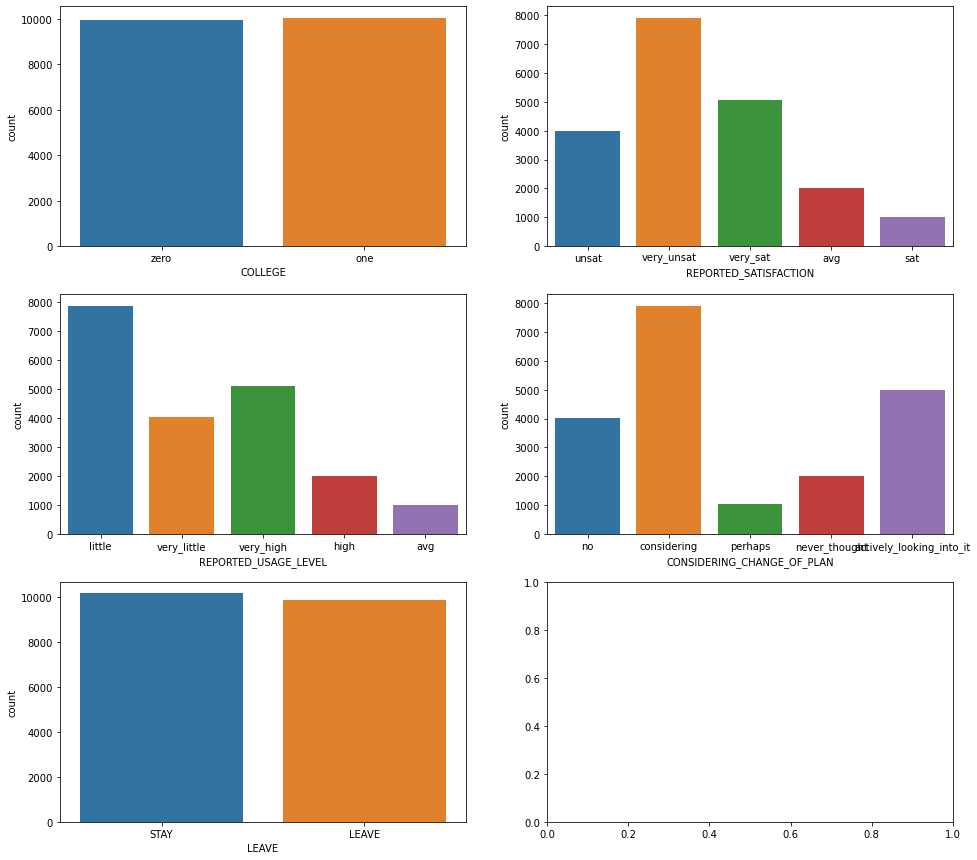

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(16,15))
sns.countplot(data = data, x='COLLEGE', ax=axes[0,0])
sns.countplot(data = data, x='REPORTED_SATISFACTION', ax=axes[0,1])
sns.countplot(data = data, x='REPORTED_USAGE_LEVEL', ax=axes[1,0])
sns.countplot(data = data, x='CONSIDERING_CHANGE_OF_PLAN', ax=axes[1,1])
sns.countplot(data = data, x='LEAVE', ax=axes[2,0])


In [26]:
var_indep_num = ['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
                 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION']

<AxesSubplot:xlabel='AVERAGE_CALL_DURATION', ylabel='Density'>

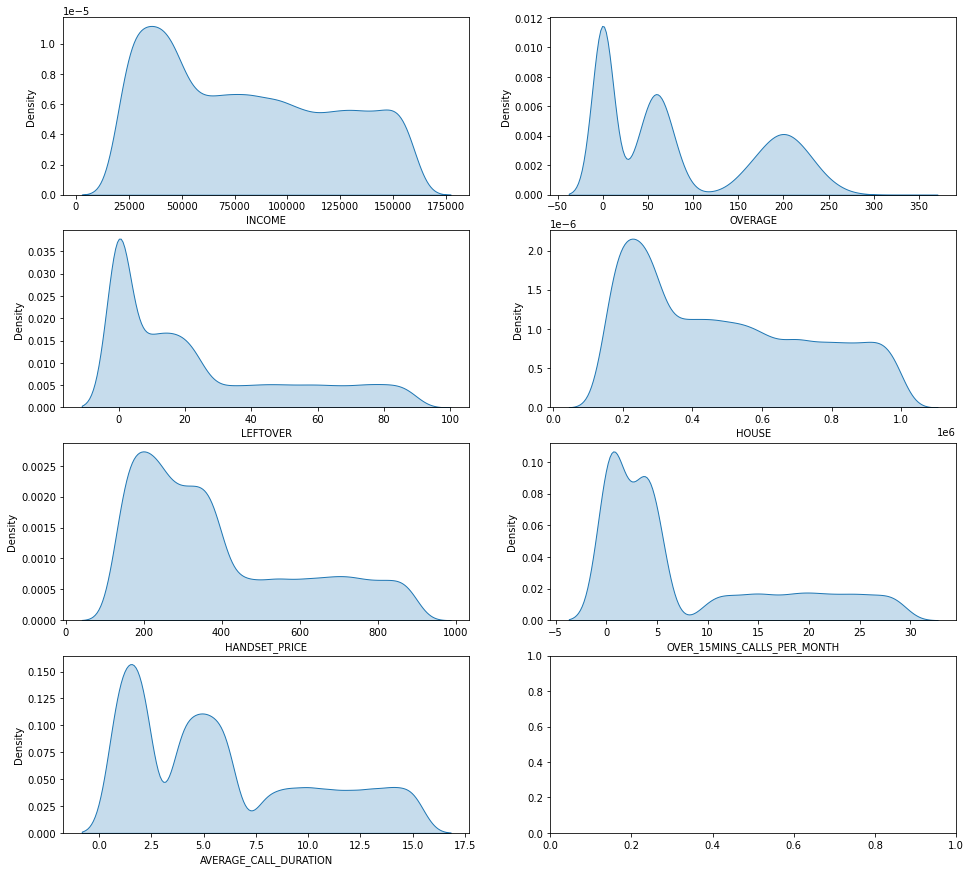

In [27]:
fig, axes = plt.subplots(4, 2, figsize=(16,15))
sns.kdeplot(data = data, x = 'INCOME', ax=axes[0,0], fill = True)
sns.kdeplot(data = data, x = 'OVERAGE', ax=axes[0,1], fill = True)
sns.kdeplot(data = data, x = 'LEFTOVER', ax=axes[1,0], fill = True)
sns.kdeplot(data = data, x = 'HOUSE', ax=axes[1,1], fill = True)
sns.kdeplot(data = data, x = 'HANDSET_PRICE', ax=axes[2,0], fill = True)
sns.kdeplot(data = data, x = 'OVER_15MINS_CALLS_PER_MONTH', ax=axes[2,1], fill = True)
sns.kdeplot(data = data, x = 'AVERAGE_CALL_DURATION', ax=axes[3,0], fill = True)

In [28]:
# sns.pairplot(data, hue = 'LEAVE')

In [29]:
d2 = data[['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
                 'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION', "LEAVE"]]
jitter = 0.3
d2.OVER_15MINS_CALLS_PER_MONTH = data.OVER_15MINS_CALLS_PER_MONTH + np.random.normal(scale=jitter, size=20000)
d2.AVERAGE_CALL_DURATION = data.AVERAGE_CALL_DURATION + np.random.normal(scale=jitter, size=20000)
plt.show()

C:\Users\Steven\AppData\Local\Temp\ipykernel_9500\2078553293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2.OVER_15MINS_CALLS_PER_MONTH = data.OVER_15MINS_CALLS_PER_MONTH + np.random.normal(scale=jitter, size=20000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9500\2078553293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2.AVERAGE_CALL_DURATION = data.AVERAGE_CALL_DURATION + np.random.normal(scale=jitter, size=20000)


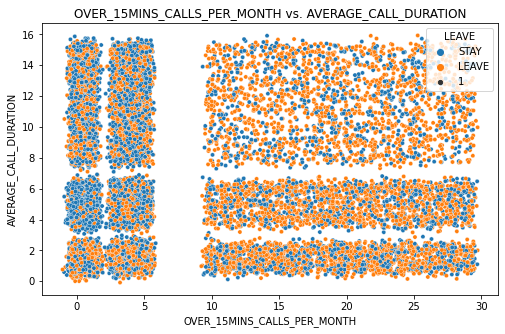

In [30]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(x="OVER_15MINS_CALLS_PER_MONTH", y="AVERAGE_CALL_DURATION", hue="LEAVE", data=d2, ax=ax, size=1)
plt.title("OVER_15MINS_CALLS_PER_MONTH vs. AVERAGE_CALL_DURATION")
plt.show()


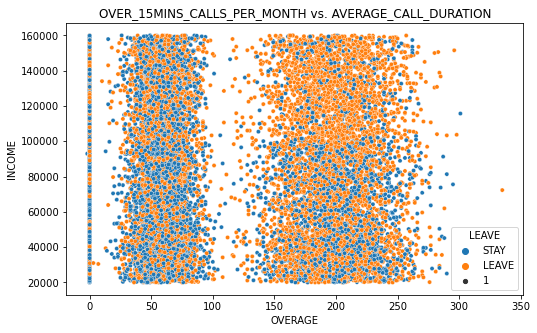

In [31]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(x="OVERAGE", y="INCOME", hue="LEAVE", data=d2, ax=ax, size=1)
plt.title("OVER_15MINS_CALLS_PER_MONTH vs. AVERAGE_CALL_DURATION")
plt.show()

# Clasificación a partir un árbol de decisión

Los árboles de decisión permiten utilizar tanto las variables predictivas categóricas como las numéricas.
No todas las variables van a ser útiles. El árbol se va a encargar de encontrar la mejor variable a utilizar en el contexto del subconjunto de datos de cada rama.

Veamos cómo se crea un árbol de decisión en scikit-learn, y algunos de los parámetros más importantes:

In [32]:
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)

**Nota editorial**: scikit-learn soporta en sus árboles de decisión solamente variables independientes numéricas!!!!! Toca entonces utilizar un encoding (dummies). Realicelo para proceder a entrenar...

In [33]:
data_dummies = pd.get_dummies(data, columns = var_indep_cat)
data_dummies.head()

INCOME  OVERAGE  LEFTOVER   HOUSE  HANDSET_PRICE  \
0   31953        0         6  313378            161   
1   36147        0        13  800586            244   
2   27273      230         0  305049            201   
3  120070       38        33  788235            780   
4   29215      208        85  224784            241   

   OVER_15MINS_CALLS_PER_MONTH  AVERAGE_CALL_DURATION  COLLEGE_one  \
0                            0                      4            0   
1                            0                      6            1   
2                           16                     15            1   
3                            3                      2            0   
4                           21                      1            1   

   COLLEGE_zero  REPORTED_SATISFACTION_avg  ...  REPORTED_USAGE_LEVEL_little  \
0             1                          0  ...                            1   
1             0                          0  ...                            1   
2             0                          0  ...                            0   
3             1                          0  ...                            0   
4             0                          0  ...                            1   

   REPORTED_USAGE_LEVEL_very_high  REPORTED_USAGE_LEVEL_very_little  \
0                               0                                 0   
1                               0                                 0   
2                               0                                 1   
3                               1                                 0   
4                               0                                 0   

   CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   CONSIDERING_CHANGE_OF_PLAN_considering  \
0                                       0   
1                                       1   
2                                       0   
3                                       1   
4                                       0   

   CONSIDERING_CHANGE_OF_PLAN_never_thought  CONSIDERING_CHANGE_OF_PLAN_no  \
0                                         0                              1   
1                                         0                              0   
2                                         0                              0   
3                                         0                              0   
4                                         1                              0   

   CONSIDERING_CHANGE_OF_PLAN_perhaps  LEAVE_LEAVE  LEAVE_STAY  
0                                   0            0           1  
1                                   0            0           1  
2                                   1            0           1  
3                                   0            1           0  
4                                   0            0           1  

[5 rows x 26 columns]

Quedarían 24 variables independientes.

In [34]:
X = data_dummies.loc[:, 'INCOME':'CONSIDERING_CHANGE_OF_PLAN_perhaps']
y = data_dummies['LEAVE_LEAVE']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
ctree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Una vez el árbol es aprendido, se puede consultar diferentes atributos.
El mas interesante, aparte del árbol en sí, es el que asocia un índice de importancia a los atributos independientes en la clasificación (Traten de graficar un diagrama de barras con los pesos y las variables de mayor a menor):

In [37]:
importance = ctree.feature_importances_
importance = pd.Series(importance)
importance = importance.sort_values(ascending= False).reset_index(drop=True)
importance

0     0.187495
1     0.180077
2     0.145923
3     0.125104
4     0.094964
5     0.056020
6     0.042450
7     0.014518
8     0.014208
9     0.013678
10    0.013300
11    0.012363
12    0.011484
13    0.010926
14    0.010868
15    0.009731
16    0.009058
17    0.008315
18    0.008281
19    0.008093
20    0.007185
21    0.005943
22    0.005766
23    0.004251
dtype: float64

In [38]:
X.columns

Index(['INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION', 'COLLEGE_one',
       'COLLEGE_zero', 'REPORTED_SATISFACTION_avg',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_avg', 'REPORTED_USAGE_LEVEL_high',
       'REPORTED_USAGE_LEVEL_little', 'REPORTED_USAGE_LEVEL_very_high',
       'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')

Encontramos entonces que las variables en orden de importancia son:

In [39]:
# columns_order = X.columns[np.argsort(-ctree.feature_importances_)]

In [40]:
columns_importance = X.columns[np.argsort(-ctree.feature_importances_)]
columns_importance = pd.Series(columns_importance)
columns_importance

0                                                 HOUSE
1                                                INCOME
2                                               OVERAGE
3                                         HANDSET_PRICE
4                                              LEFTOVER
5                           OVER_15MINS_CALLS_PER_MONTH
6                                 AVERAGE_CALL_DURATION
7                CONSIDERING_CHANGE_OF_PLAN_considering
8                      REPORTED_SATISFACTION_very_unsat
9                           REPORTED_USAGE_LEVEL_little
10    CONSIDERING_CHANGE_OF_PLAN_actively_looking_in...
11                     REPORTED_USAGE_LEVEL_very_little
12                        CONSIDERING_CHANGE_OF_PLAN_no
13                                         COLLEGE_zero
14                       REPORTED_SATISFACTION_very_sat
15                            REPORTED_SATISFACTION_avg
16                       REPORTED_USAGE_LEVEL_very_high
17             CONSIDERING_CHANGE_OF_PLAN_never_

In [41]:
data_importance = pd.concat([columns_importance, importance], axis = 1)
data_importance = data_importance.rename(columns = {0:'columns_importance', 1:'importance'})
data_importance = data_importance.sort_values(by = 'importance', ascending = False)
data_importance

columns_importance  importance
0                                               HOUSE    0.187495
1                                              INCOME    0.180077
2                                             OVERAGE    0.145923
3                                       HANDSET_PRICE    0.125104
4                                            LEFTOVER    0.094964
5                         OVER_15MINS_CALLS_PER_MONTH    0.056020
6                               AVERAGE_CALL_DURATION    0.042450
7              CONSIDERING_CHANGE_OF_PLAN_considering    0.014518
8                    REPORTED_SATISFACTION_very_unsat    0.014208
9                         REPORTED_USAGE_LEVEL_little    0.013678
10  CONSIDERING_CHANGE_OF_PLAN_actively_looking_in...    0.013300
11                   REPORTED_USAGE_LEVEL_very_little    0.012363
12                      CONSIDERING_CHANGE_OF_PLAN_no    0.011484
13                                       COLLEGE_zero    0.010926
14                     REPORTED_SATISFACTION_very_sat    0.010868
15                          REPORTED_SATISFACTION_avg    0.009731
16                     REPORTED_USAGE_LEVEL_very_high    0.009058
17           CONSIDERING_CHANGE_OF_PLAN_never_thought    0.008315
18                                        COLLEGE_one    0.008281
19                        REPORTED_SATISFACTION_unsat    0.008093
20                          REPORTED_USAGE_LEVEL_high    0.007185
21                           REPORTED_USAGE_LEVEL_avg    0.005943
22                 CONSIDERING_CHANGE_OF_PLAN_perhaps    0.005766
23                          REPORTED_SATISFACTION_sat    0.004251

In [42]:
df = pd.DataFrame(list(zip(X.columns, ctree.feature_importances_)))
df.sort_values(by=1,ascending = False, inplace=True)
df

0         1
3                                               HOUSE  0.187495
0                                              INCOME  0.180077
1                                             OVERAGE  0.145923
4                                       HANDSET_PRICE  0.125104
2                                            LEFTOVER  0.094964
5                         OVER_15MINS_CALLS_PER_MONTH  0.056020
6                               AVERAGE_CALL_DURATION  0.042450
20             CONSIDERING_CHANGE_OF_PLAN_considering  0.014518
13                   REPORTED_SATISFACTION_very_unsat  0.014208
16                        REPORTED_USAGE_LEVEL_little  0.013678
19  CONSIDERING_CHANGE_OF_PLAN_actively_looking_in...  0.013300
18                   REPORTED_USAGE_LEVEL_very_little  0.012363
22                      CONSIDERING_CHANGE_OF_PLAN_no  0.011484
8                                        COLLEGE_zero  0.010926
12                     REPORTED_SATISFACTION_very_sat  0.010868
9                           REPORTED_SATISFACTION_avg  0.009731
17                     REPORTED_USAGE_LEVEL_very_high  0.009058
21           CONSIDERING_CHANGE_OF_PLAN_never_thought  0.008315
7                                         COLLEGE_one  0.008281
11                        REPORTED_SATISFACTION_unsat  0.008093
15                          REPORTED_USAGE_LEVEL_high  0.007185
14                           REPORTED_USAGE_LEVEL_avg  0.005943
23                 CONSIDERING_CHANGE_OF_PLAN_perhaps  0.005766
10                          REPORTED_SATISFACTION_sat  0.004251

<AxesSubplot:xlabel='columns_importance', ylabel='importance'>

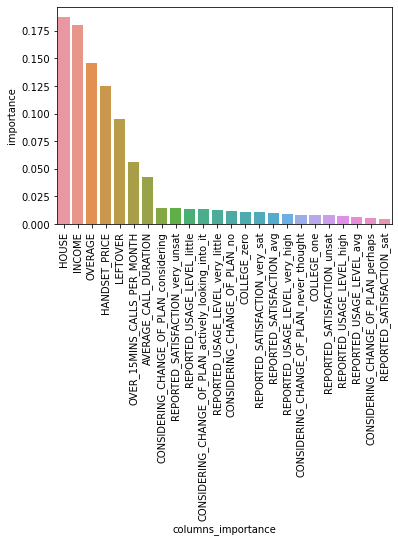

In [43]:
plt.xticks(rotation = 90)
sns.barplot(data = data_importance, x = 'columns_importance', y = 'importance')

Vamos ahora a visualizar el árbol aprendido (para hacerlo, se necesita preinstalar la aplicación graphviz).

In [44]:
import pydotplus
from IPython.display import Image  
from six import StringIO  

In [45]:
dot_data = StringIO()
tree.export_graphviz(ctree, 
                     filled=True, rounded=True,  #nodos redondeados y coloreados
                     class_names=str(ctree.classes_),
                     feature_names=X_train.columns,  
                     out_file=dot_data,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.240448 to fit



La imágen es demasiado grande para poder visualizarla aquí, vamos a guardarla un archivo y abrirla en un visor externo que permita hacer zoom.

In [47]:
# Create PNG
graph.write_png("arbol.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.240448 to fit



True

Como se puede ver el árbol es increiblemente grande y complejo, pues no se especificó ninguna manera de limitar su crecimiento.

## Evaluación del modelo

Ya tenemos el modelo "aprendido" con el dataset de 20000 instancias.
Vamos ahora a evaluarlo sobre ese mismo dataset para poder ver los éxitos y errores de la predicción. 

In [48]:
y_pred = ctree.predict(X_test)

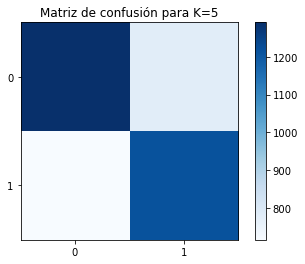

In [49]:
cm= metrics.confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Matriz de confusión para K=5")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, y_test.unique())
plt.yticks(tick_marks, y_test.unique())
plt.show()

In [52]:
print(cm)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))
print("Precisión     : ", metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, average='macro'))
VN = np.sum(cm[1:3,1:3])
FP = np.sum(cm[0,1:3])
specificity = VN/(VN+FP)
print("Especificidad : ", specificity)
print("F1-score      : ", metrics.f1_score(y_test, y_pred, average='macro'))


[[1291  778]
 [ 716 1215]]
Exactitud:  0.6265
Kappa    :  0.25290978885700444
Precisión     :  0.6264411739043803
Recall        :  0.6265902991035079
Especificidad :  0.6096337180130457
F1-score      :  0.6263651178075285


Con el árbol completo, obtuvimos un nivel de accuracy del 61.68%, cuando el baseline era de 50.74%.

## Overfitting: poda del árbol

Vamos a ver que hubiera pasado si limitamos el crecimiento del árbol (prepoda), controlando la profundidad del árbol y el mínimo número de registros de un nodo para permitir el particionamiento.

**Parte 3**:

Modifiquen el parámetro **criterion** y los parámetros de pre-poda buscando una mejor exactitud del modelo:
- **max_depth**: entre mas grande el valor, el árbol será más complejo (más número de niveles de profundidad)
- **min_samples_split**: entre mas grande el valor, el árbol será más sencillo (se necesita tener más registros en un nodo para poder particionarlo)
- **min_samples_leaf**: entre mas grande el valor, el árbol será más sencillo (se necesita tener más registros en una hoja para poder aceptarla, si no se llega a esa cardinalidad, no se permite el partionamiento de su nodo padre) 
- **min_impurity_decrease**: entre mas grande el valor, el árbol será más sencillo (un nivel de impureza bajo inferior a este umbral no desatará un particionamiento. 


In [80]:
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos
    max_depth=5,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
    random_state=123,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)
ctree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)

In [81]:
y_pred = ctree.predict(X_test)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))

Exactitud:  0.696


In [84]:
dot_data = StringIO()
tree.export_graphviz(ctree, 
                     filled=True, rounded=True,  #nodos redondeados y coloreados
                     class_names=ctree.classes_,
                     feature_names= str(X_train.columns),  
                     out_file= dot_data,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ValueError: Length of feature_names, 781 does not match number of features, 24

Podríamos seguir mejorando el árbol buscando un tuning de la prepoda mas complejo con los demás parámetros.

Podemos intentar con otro tipo de modelos, e.g KNN.

In [60]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1234)
knn = KNeighborsClassifier(n_neighbors=300)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.626
Kappa    :  0.26374782378670336


También con un modelo Naive Bayes 

In [61]:
from sklearn.naive_bayes import GaussianNB
np.random.seed(1234)
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.6425
Kappa    :  0.2818409980903499


## Modelos de ensamble: bagging, random forest, boosting

## Bagging

Vamos ahora a crear un modelo de ensamble que utiliza muchos modelos de árboles sencillos que pone a votar para encontrar una decisión consensuada.

In [62]:
from sklearn.ensemble import BaggingClassifier
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos
    max_depth=7,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=1000, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)
bagging = BaggingClassifier(base_estimator = ctree,   # Por defecto un decision tree 
                            n_estimators=200,          # Número de modelos a crear
                            max_samples=0.7,          # Número o % de registros de la muestra de aprendizaje
                            max_features=0.7,         # Número o % de atributos de la muestra de aprendizaje
                            bootstrap=True,           # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                            bootstrap_features=False, # Utilizar reemplazo en el muestreo de los atributos de aprendizaje
                            oob_score=False,          # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
                            n_jobs=2,                 # Número de cores a utilizar
                            random_state=None,        # random seed para el generador aleatorio
                            verbose=0)                # controla la cantidad de información a reportar


In [63]:
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.69925
Kappa    :  0.40135017183190824


Podemos hacer bagging de otro tipo de estimadores de base, por ejemplo KNN.

In [64]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1234)
bagging = BaggingClassifier(base_estimator = KNeighborsClassifier(),   # Por defecto un decision tree 
                            n_estimators=50,          # Número de modelos a crear
                            max_samples=0.5,          # Número o % de registros de la muestra de aprendizaje
                            max_features=0.5,         # Número o % de atributos de la muestra de aprendizaje
                            bootstrap=True,           # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                            bootstrap_features=False, # Utilizar reemplazo en el muestreo de los atributos de aprendizaje
                            oob_score=False,          # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
                            n_jobs=2,                 # Número de cores a utilizar
                            random_state=None,        # random seed para el generador aleatorio
                            verbose=0)                # controla la cantidad de información a reportar

bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.6515
Kappa    :  0.30272335549129115


## Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1234)
rforest = RandomForestClassifier(n_estimators=100,     #Número de modelos a crear 
                                criterion='entropy', # el criterio de particionamiento de un conjunto de datos
                                max_depth=6,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
                                min_samples_split=1000, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
                                min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
                                max_features=('auto'), # Número o % de atributos de la muestra de aprendizaje
                                max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
                                min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
                                bootstrap=True,      # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                                oob_score=True,     # Evaluar cada modelo con los registros no utilizados en su aprendizaje 
                                n_jobs=2,            # Número de cores a utilizar
                                random_state=None,   # random seed para el generador aleatorio
                                verbose=0)           # controla la cantidad de información a reportar
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
cm= metrics.confusion_matrix(y_test, y_pred)
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa    : ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.696
Kappa    :  0.389504140301588


In [66]:
rforest.oob_score_

0.6941875

Encontramos que las variables en orden de importancia son:

In [67]:
X.columns[np.argsort(-rforest.feature_importances_)]

Index(['HOUSE', 'OVERAGE', 'OVER_15MINS_CALLS_PER_MONTH', 'INCOME', 'LEFTOVER',
       'HANDSET_PRICE', 'AVERAGE_CALL_DURATION',
       'CONSIDERING_CHANGE_OF_PLAN_perhaps', 'COLLEGE_one',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_unsat', 'REPORTED_SATISFACTION_very_sat',
       'CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'REPORTED_SATISFACTION_avg',
       'CONSIDERING_CHANGE_OF_PLAN_considering', 'REPORTED_USAGE_LEVEL_little',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'REPORTED_USAGE_LEVEL_very_little', 'REPORTED_USAGE_LEVEL_very_high',
       'COLLEGE_zero', 'REPORTED_USAGE_LEVEL_avg',
       'REPORTED_USAGE_LEVEL_high'],
      dtype='object')

## Boosting

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import zero_one_loss
np.random.seed(1234)

numModelos = 400
ada_10 = AdaBoostClassifier(base_estimator=None,  #Por defecto se trata de decision stumps
                         n_estimators=numModelos,     #Número de modelos a crear
                         algorithm='SAMME',
                         learning_rate=1.0)    #Reduce la importancia de los modelos mas recientes
ada_10.fit(X_train, y_train)
ada_02 = AdaBoostClassifier(base_estimator=None,  #Por defecto se trata de decision stumps
                         n_estimators=numModelos,     #Número de modelos a crear
                        algorithm='SAMME',
                         learning_rate=0.2)    #Reduce la importancia de los modelos mas recientes

ada_02.fit(X_train, y_train)
ada_005 = AdaBoostClassifier(base_estimator=None,  #Por defecto se trata de decision stumps
                         n_estimators=numModelos,     #Número de modelos a crear
                         algorithm='SAMME',
                         learning_rate=0.05)    #Reduce la importancia de los modelos mas recientes
ada_005.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.05, n_estimators=400)

In [69]:
ada_errores_test_10 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_10.staged_predict(X_test)):
    ada_errores_test_10[i] = 1-zero_one_loss(y_pred, y_test)
ada_errores_train_10 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_10.staged_predict(X_train)):
    ada_errores_train_10[i] = 1-zero_one_loss(y_pred, y_train)

A:\Programar\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
A:\Programar\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [70]:
ada_errores_test_02 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_02.staged_predict(X_test)):
    ada_errores_test_02[i] = 1-zero_one_loss(y_pred, y_test)
ada_errores_train_02 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_02.staged_predict(X_train)):
    ada_errores_train_02[i] = 1-zero_one_loss(y_pred, y_train)

A:\Programar\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
A:\Programar\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [71]:
ada_errores_test_005 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_005.staged_predict(X_test)):
    ada_errores_test_005[i] = 1-zero_one_loss(y_pred, y_test)

ada_errores_train_005 = np.zeros((numModelos,))
for i, y_pred in enumerate(ada_005.staged_predict(X_train)):
    ada_errores_train_005[i] = 1-zero_one_loss(y_pred, y_train)

A:\Programar\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
A:\Programar\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


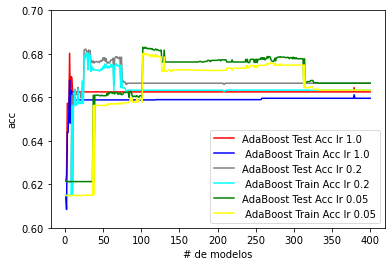

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(numModelos) + 1, ada_errores_test_10,
        label='AdaBoost Test Acc lr 1.0',
        color='red')
ax.plot(np.arange(numModelos) + 1, ada_errores_train_10,
        label=' AdaBoost Train Acc lr 1.0',
        color='blue')
ax.plot(np.arange(numModelos) + 1, ada_errores_test_02,
        label='AdaBoost Test Acc lr 0.2',
        color='gray')
ax.plot(np.arange(numModelos) + 1, ada_errores_train_02,
        label=' AdaBoost Train Acc lr 0.2',
        color='cyan')
ax.plot(np.arange(numModelos) + 1, ada_errores_test_005,
        label='AdaBoost Test Acc lr 0.05',
        color='green')
ax.plot(np.arange(numModelos) + 1, ada_errores_train_005,
        label=' AdaBoost Train Acc lr 0.05',
        color='yellow')

ax.set_ylim((0.6, 0.7))
ax.set_xlabel('# de modelos')
ax.set_ylabel('acc')

leg = ax.legend(loc='lower right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()